In [3]:
from yroots.utils import condeigs
from yroots.polyroots import solve
from yroots.Multiplication import *
import yroots as yr
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from tests.devastating_example_test_scripts import *
from tests.growth_factors import *
from scipy.stats import linregress
from scipy.spatial.distance import pdist
%load_ext autoreload
%autoreload 2

In [59]:
for poly in randpoly(2,.001,'power'):
    print(poly.coeff)

[[0.00000000e+00 9.86413658e-04]
 [1.64280536e-04 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
[[ 0.00000000e+00  1.64280536e-04  1.00000000e+00]
 [-9.86413658e-04  0.00000000e+00  0.00000000e+00]]


Recall that the condition number of a simple root $z$ of $f:\mathbb{R}^n\mapsto\mathbb{R}^n$ is:
    $$\kappa(z,f) = \left\lVert{Df(z)^{-1}}\right\rVert_2$$
and that the condition number of a simple eigenvalue $\lambda$ of A such that $Ax = \lambda x$ and $A^*y = \lambda y$ is:
    $$\kappa(\lambda,A) = \frac{\left\lVert{x}\right\rVert \left\lVert{y}\right\rVert}{|y^*x|}$$
    
Define the \textit{growth factor} for a M\"oller-Stetter eigenproblem for an eigenvalue $\lambda$ corresponding to a root $z$ to be:
    $$GF(\lambda,z,f,m_h) = \log_{10}\frac{\kappa(\lambda,m_h)}{\kappa(z,f)}$$
    
This measures how many additional digits of precision may be lost when converting the root-finding problem into an eigenproblem.

<img src="growthfactor.png" width=600 height=600 />


# loading in data saved from the server

### random systems

In [48]:
folder = 'tests/growth_factors/rand/newton/'
normal_masks = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy')\
                for d in range(3,7)}
normal_masks[7] = np.ones(200,dtype=bool)
normal_masks[2] = np.ones(300,dtype=bool)
rand_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks[d]])
                      for d in range(2,8)}
rand_polished[8] = np.stack([np.load(folder+f'dim8/deg2_sys{i}.npy')
                                 for i in range(23)])
for d in rand_polished.keys():
    print(rand_polished[d].shape)

(300, 2, 4)
(295, 3, 8)
(298, 4, 16)
(298, 5, 32)
(198, 6, 64)
(200, 7, 128)
(23, 8, 256)


### devastating systems

In [3]:
folder = 'tests/growth_factors/dev/newton/'
dev_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,7)}
dev_polished[7] = [np.load(folder+f'dim7/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(45)]
dev_polished[8] = [np.load(folder+f'dim8/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(25)]
#I accidentally saved the converging root info-- so let's check that out now and then remove it
for d in dev_polished.keys():
    for i,sys in enumerate(dev_polished[d]):
        if d > 6:
            sys = sys[0]
        gf,newt_dist,root_dist = sys
        if not 10*newt_dist < root_dist:
            print(d,i)
            print('**Potentially converging roots with polishing**')
            print(f'\tNewton changed roots by at most: {newt_dist}')
            print(f'\tDist between root was at least:  {root_dist}')
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in [7,8]:
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in dev_polished.keys():
    print(dev_polished[d].shape)  

(50, 2)
(50, 3)
(50, 4)
(50, 5)
(50, 6)
(45, 7)
(25, 8)


### comparison to without polishing

ls tests/growth_factors/rand/nopol/dim3

folder = 'tests/growth_factors/rand/nopol/'
normal_masks_nopol = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy') for d in range(3,5)}
normal_masks_nopol[2] = np.ones(300,dtype=bool)
rand_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks_nopol[d]])
                      for d in range(2,5)}
for d in rand_nopol.keys():
    print(rand_nopol[d].shape)

folder = 'tests/growth_factors/dev/nopol/'
dev_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,5)}
for d in dev_nopol.keys():
    print(dev_nopol[d].shape)  

# devastating example
run the same code on devastating examples with eps = .1 to show empirical line, with a perturbed coefficient tensor too to show it gets nice if you do that

In [34]:
gf_dev_1 = devastating_growth_factors([2,3,4],.1,'power',newton=False,save=False)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [35]:
gf_dev_2 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [36]:
gf_dev_1_delta3 = devastating_growth_factors([2,3,4],.1,'power',perturb_eps=.001,newton=False,save=False)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [51]:
gf_dev_2_delta_1 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False,perturb_eps=.1)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [37]:
gf_dev_2_delta_2 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False,perturb_eps=.01)


devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [38]:
gf_dev_2_delta3 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False,perturb_eps=.001)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [39]:
gf_dev_2_delta4 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False,perturb_eps=.0001)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

In [40]:
gf_dev_2_delta_5 = devastating_growth_factors([2,3,4],.01,'power',newton=False,save=False,perturb_eps=.00001)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

devastating Systems, $\epsilon=.01$
Slope: 1.99999853923155 
Intercept: -1.9999733345944675

Perturbed devastating Systems, $\epsilon=.01, \delta=.1$
Slope: 0.4130133594593585 
Intercept: -0.5607253048220882

Perturbed devastating Systems, $\epsilon=.01, \delta=.01$
Slope: 0.920409745658012 
Intercept: -1.0900875820766205

Perturbed devastating Systems, $\epsilon=.01, \delta=.001$
Slope: 1.333339472793583 
Intercept: -1.4763311708869438

Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$
Slope: 1.7642487415358612 
Intercept: -1.862662605212451

Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$
Slope: 2.0002693537571408 
Intercept: -2.0550149918994265

Random Systems
Slope: 0.049974162632344575 
Intercept: 0.20151817188668214



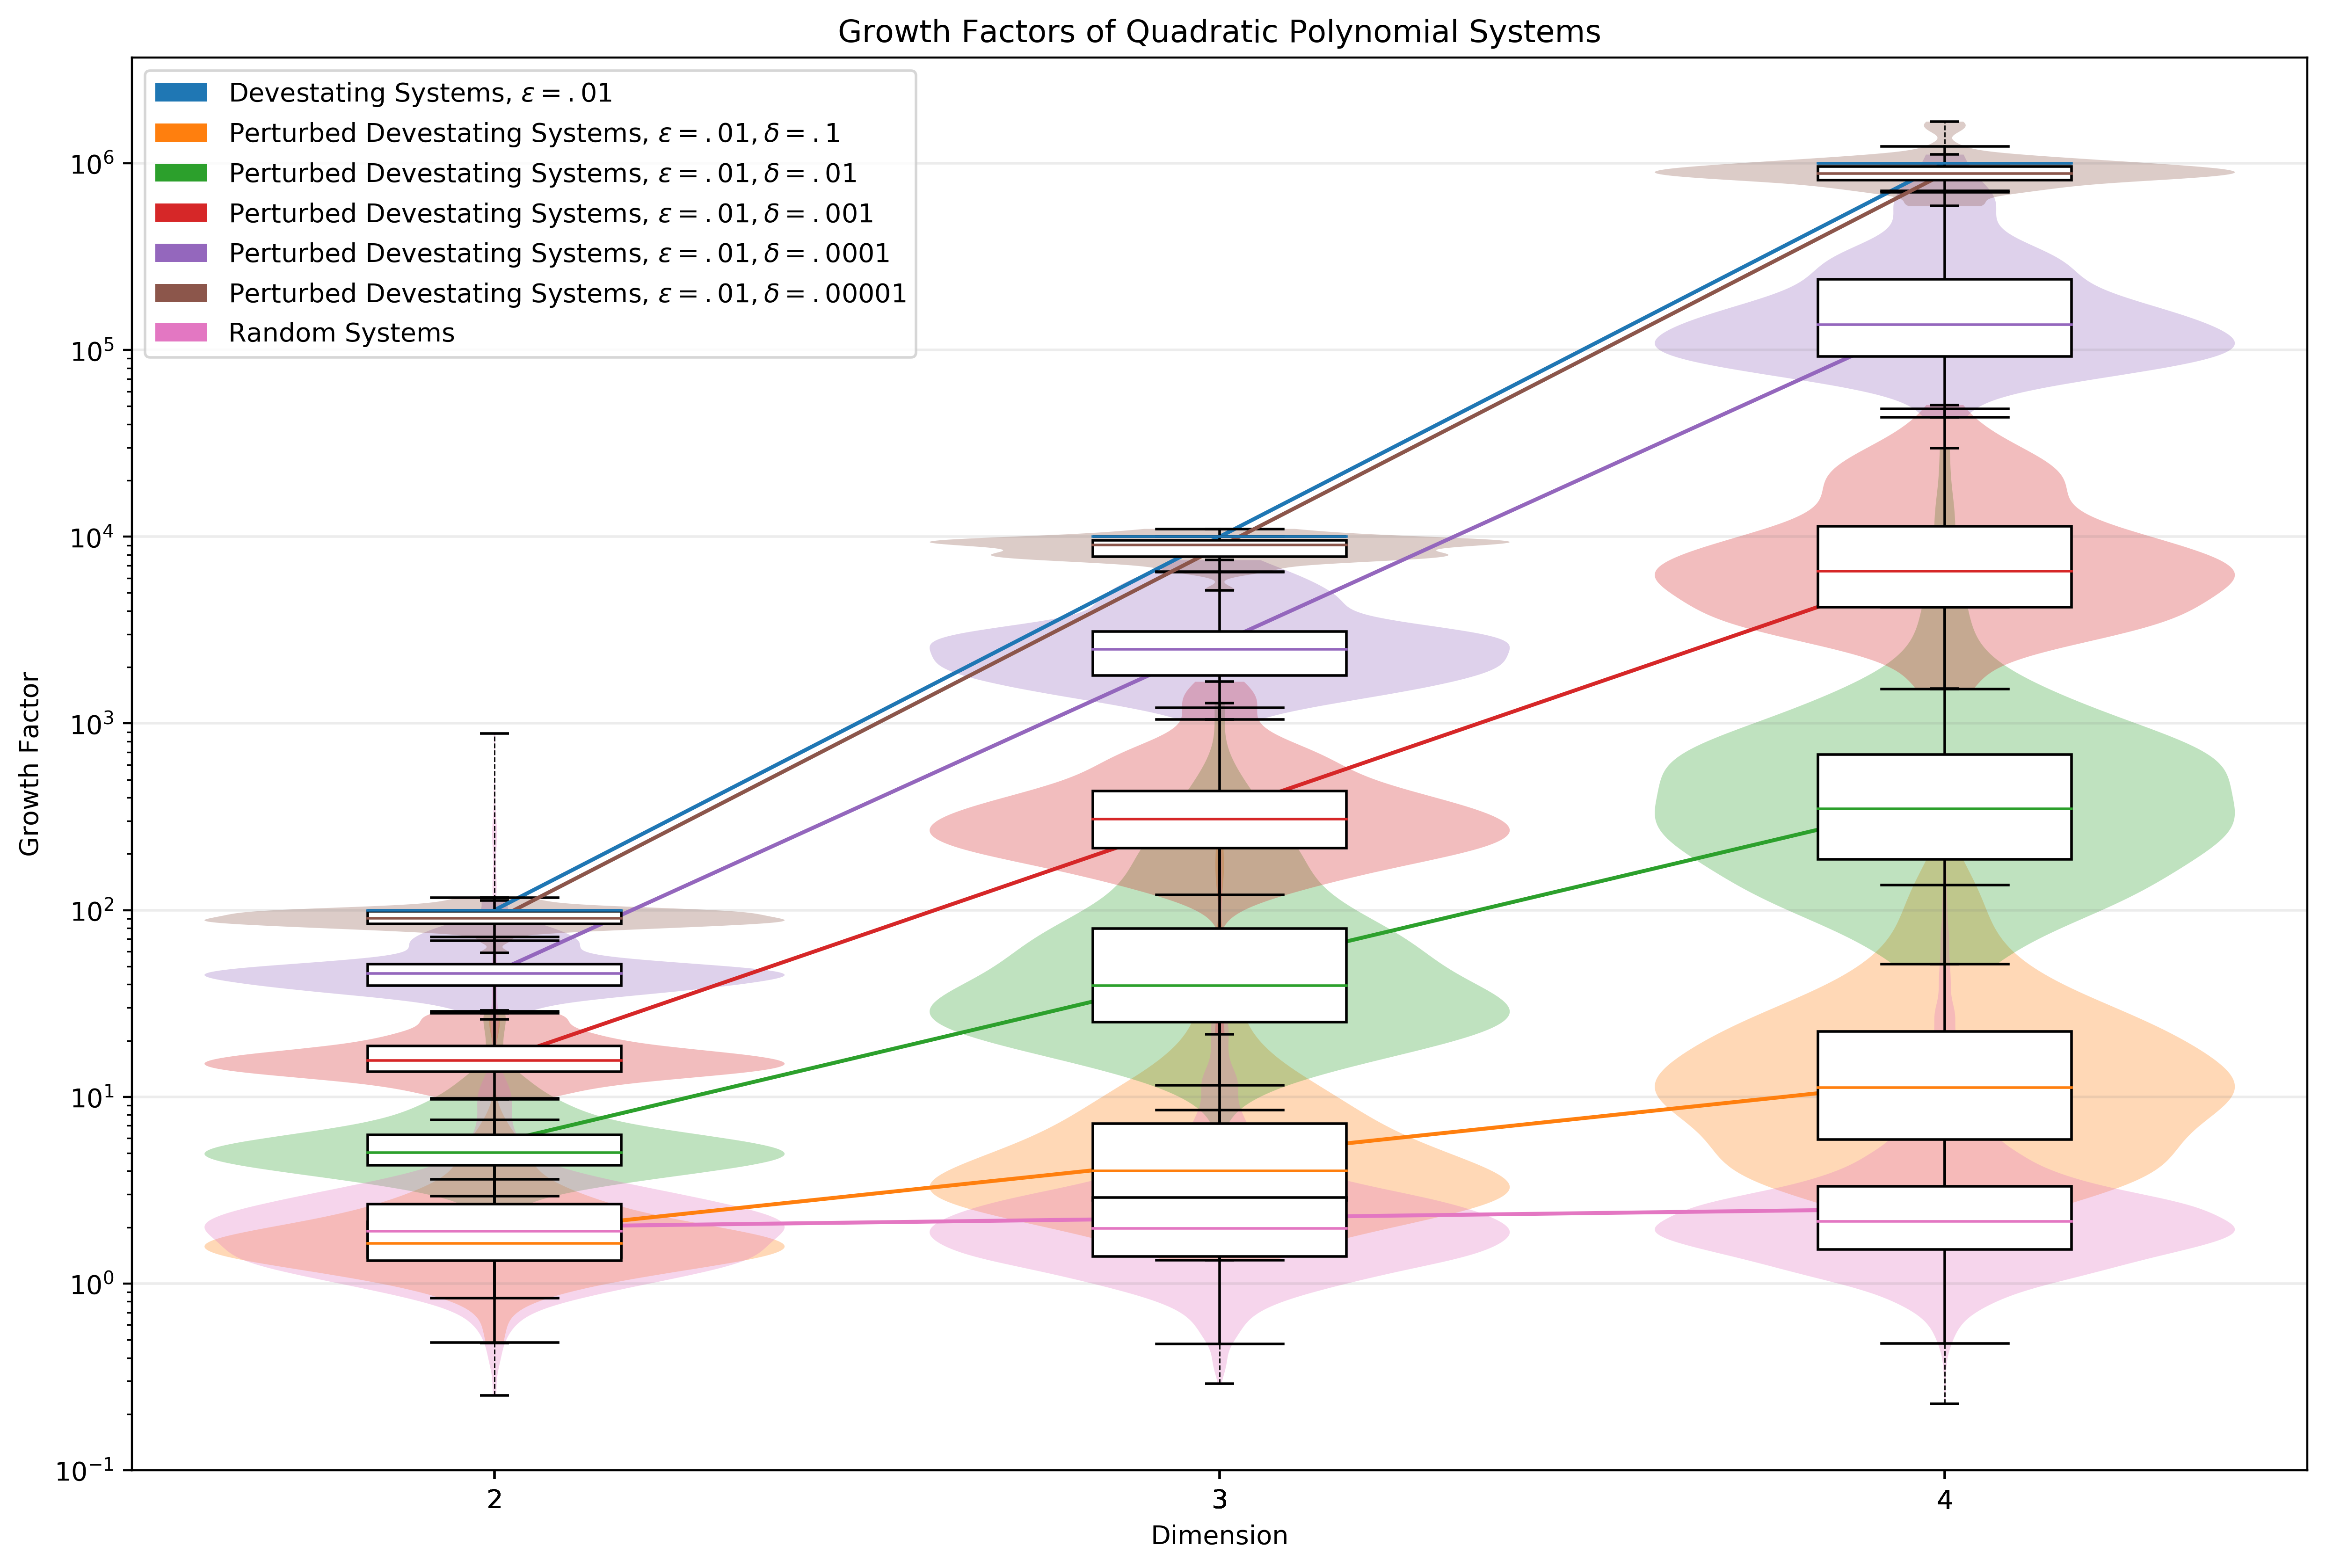

In [53]:
plot([#gf_dev_1,
      gf_dev_2,
#       gf_dev_1_delta3,
      gf_dev_2_delta_1,
      gf_dev_2_delta_2,
      gf_dev_2_delta3,
      gf_dev_2_delta4,
      gf_dev_2_delta_5,
      {d:rand_polished[d] for d in range(2,5)}],
     [#r'devastating Systems, $\epsilon=.1$',
      r'devastating Systems, $\epsilon=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.1$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$',
      r'Random Systems'],
     figsize=(15,10))

In [60]:
slopes = [1.99999853923155,
          2.0002693537571408,
          1.7642487415358612,
          1.333339472793583,
          0.920409745658012,
          0.4130133594593585]
deltas = [0,1e-5,1e-4,1e-3,1e-2,1e-1]

In [69]:
np.linspace(1e-5,1e-1)

array([1.00000000e-05, 2.05061224e-03, 4.09122449e-03, 6.13183673e-03,
       8.17244898e-03, 1.02130612e-02, 1.22536735e-02, 1.42942857e-02,
       1.63348980e-02, 1.83755102e-02, 2.04161224e-02, 2.24567347e-02,
       2.44973469e-02, 2.65379592e-02, 2.85785714e-02, 3.06191837e-02,
       3.26597959e-02, 3.47004082e-02, 3.67410204e-02, 3.87816327e-02,
       4.08222449e-02, 4.28628571e-02, 4.49034694e-02, 4.69440816e-02,
       4.89846939e-02, 5.10253061e-02, 5.30659184e-02, 5.51065306e-02,
       5.71471429e-02, 5.91877551e-02, 6.12283673e-02, 6.32689796e-02,
       6.53095918e-02, 6.73502041e-02, 6.93908163e-02, 7.14314286e-02,
       7.34720408e-02, 7.55126531e-02, 7.75532653e-02, 7.95938776e-02,
       8.16344898e-02, 8.36751020e-02, 8.57157143e-02, 8.77563265e-02,
       8.97969388e-02, 9.18375510e-02, 9.38781633e-02, 9.59187755e-02,
       9.79593878e-02, 1.00000000e-01])

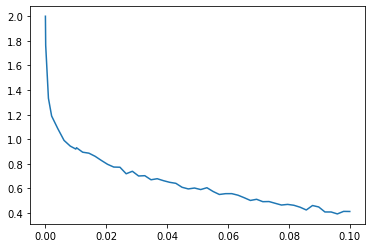

In [93]:
srt = np.argsort(deltas)
deltas = np.array(deltas)
slopes = np.array(slopes)
plt.plot(deltas[srt],slopes[srt])
# plt.plot(deltas[srt],1/deltas[srt])
plt.show()

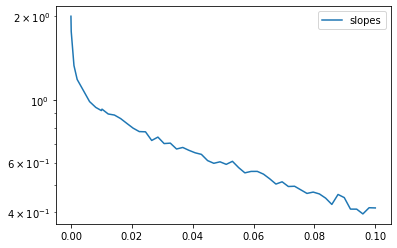

In [105]:
plt.semilogy(deltas[srt],slopes[srt],label='slopes')
plt.legend()
plt.show()

In [70]:
for delta in np.linspace(1e-5,1e-1):
    data = devastating_growth_factors([2,3,4],.01,
                                      'power',
                                      newton=False,
                                      save=False,
                                      perturb_eps=delta)
    data_log10 = [np.log10(data[d].flatten()) for d in data.keys()]
    points = np.array([[d,val] for i,d in enumerate(data.keys()) for val in data_log10[i]])
    slope = linregress(points)[0]
    deltas.append(delta)
    slopes.append(slope)

devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
2

7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 do

19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40

27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in

37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done


1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 

15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36

41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
3
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
4
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
devastating Example in dimensions [2, 3, 4]
2
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
1

summary: 

perturbing opens up new choices of basis

cond num probably isn't cont at zero

# data info

In [4]:
def get_log_medians(data):
    return [np.median(np.log10(data[d])) for d in data.keys()]
def get_perc_neg(data):
    return [np.mean(np.log10(data[d])<0)*100 for d in data.keys()]

# plotting

plot([gf_dev_1,shifted_gf_dev_1,gf_dev_2,shifted_gf_dev_2],
     [r'devastating Systems, $\epsilon=.1$',r'Shifted devastating Systems, $\epsilon=.1$',
      r'devastating Systems, $\epsilon=.01$',r'Shifted devastating Systems, $\epsilon=.01$'],
     figsize=(15,10))

0.042297149196839905 0.24599742391990143
1.0000433894444425 -0.9981340387625659


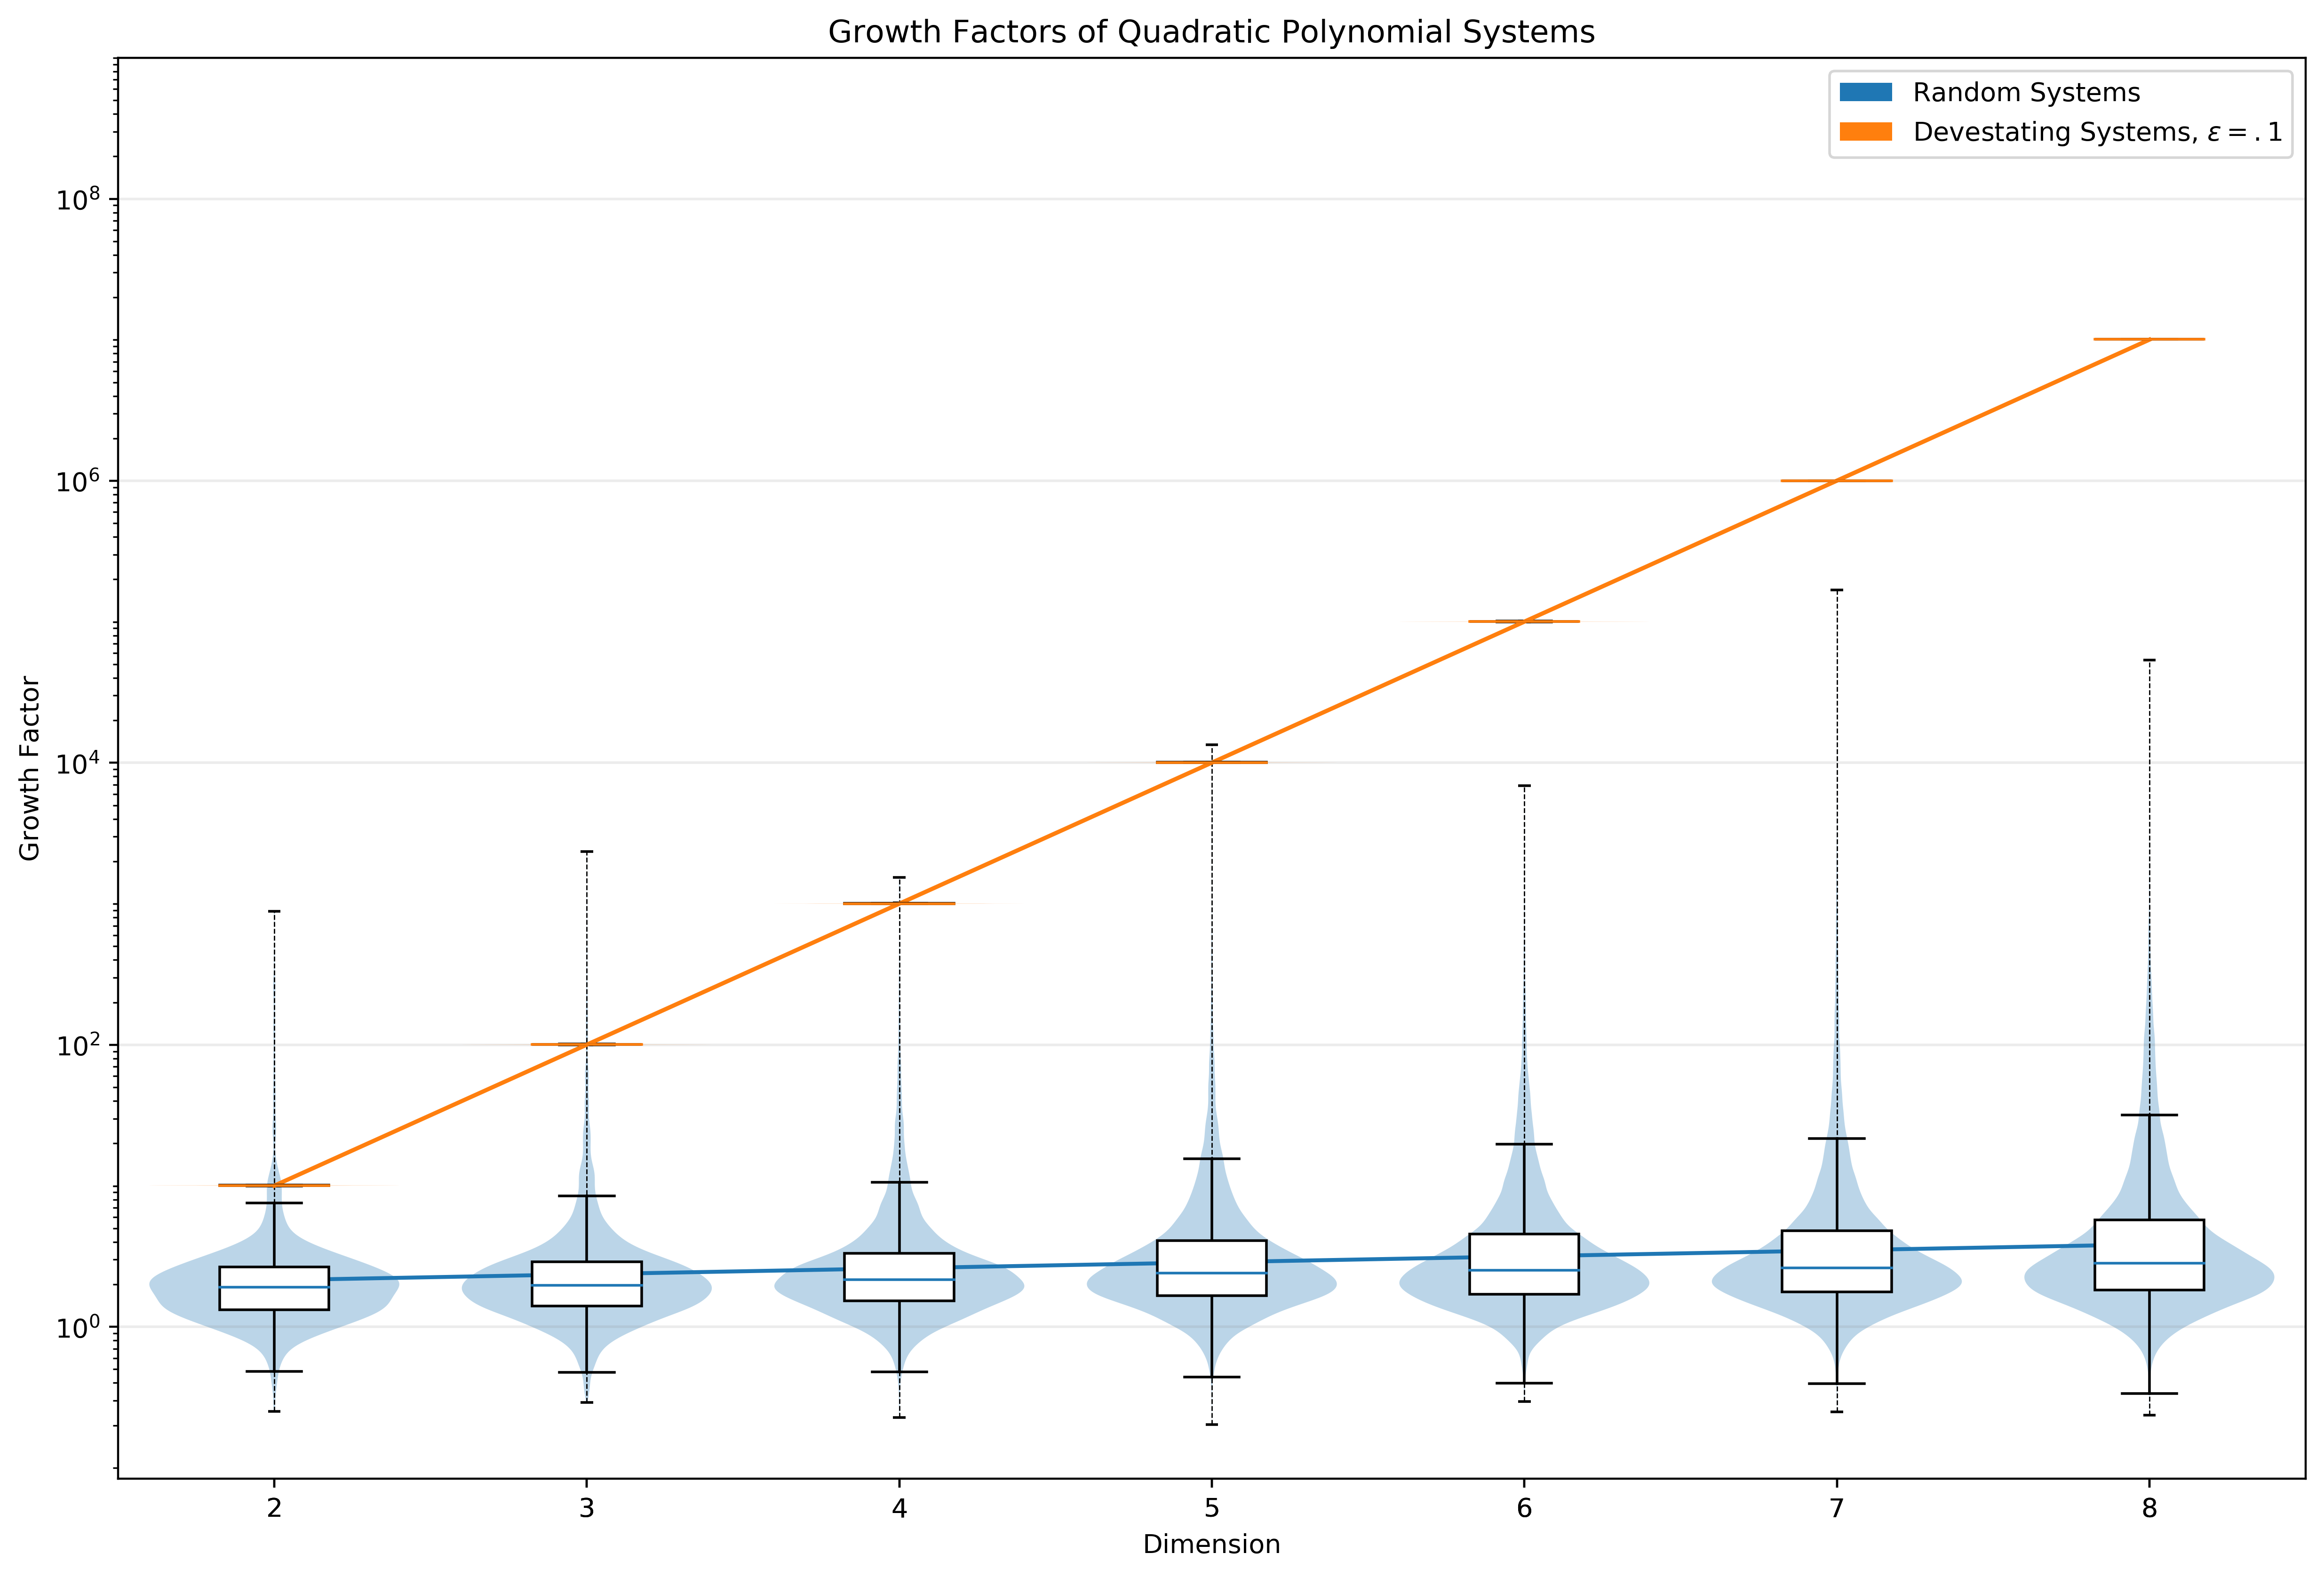

In [6]:
plot([rand_polished,dev_polished],
     ['Random Systems',r'devastating Systems, $\epsilon=.1$'],
     figsize=(15,10))

* figsize is the desired actual size in the final printed article, measured in inches -- controlable
* dpi at least 300 -- defaults to 400
* file type  pdf -- does that in saving
* bbox_inches = ‘tight’ -- does that in saving

In [8]:
print('log medians')
print('Rand:',np.round(get_log_medians(rand_polished),4))
print('Dev :',np.round(get_log_medians(dev_polished),4))
print('Rand % Negative:',np.round(get_perc_neg(rand_polished),4))

log medians
Rand: [0.2801 0.2958 0.3331 0.3817 0.4027 0.4176 0.452 ]
Dev : [1.0028 2.0018 3.0015 4.0021 5.0019 6.0012 7.0034]
Rand % Negative: [9.5833 9.096  6.9107 5.0902 4.2508 3.7985 3.8086]


# weird errors: svd on dim 7

polys = devastating_growth_factors([7],.1,'power',newton=True,N=50,just_dev_root=True,seed=468,perturb_eps=0,save=False)

polys

M,terms,cut = yr.polysolve(polys)

M.shape

reduce_macaulay_svd(M,cut)

# why??? why you no have 8 roots?

it was basically because the numerical rank was sometimes incorrect, i.e. didn't match the bezout bound

In [ ]:
weird_masks = {d:~normal_masks[d] for d in normal_masks.keys()}

In [ ]:
where_weird = {d:np.where(weird_masks[d])[0] for d in weird_masks.keys()}

In [ ]:
where_weird

# I've noticed it's not consistent between the server and my computer which ones it doesn't get enough roots on. Like some always fail, and some only fail sometimes

e.g. 10 is showing up as weird here, but not when i run it on my computer

In [ ]:
def plot_scree(s,tol,dim,sys_num):
    plt.semilogy(s,marker='.')
    plt.plot(np.ones(len(s))*tol)
    plt.show()

In [ ]:
coeffs3d = np.load('tests/random_tests/coeffs/dim3_deg2_randn.npy')

In [ ]:
coeffs4d = np.load('tests/random_tests/coeffs/dim4_deg2_randn.npy')

In [ ]:
def plot_sys(dim,sys_num):
    print('System Number',sys_num)
    if   dim == 4: polys = [yr.MultiPower(c) for c in coeffs4d[sys_num]]
    elif dim == 3: polys = [yr.MultiPower(c) for c in coeffs3d[sys_num]]
    roots,M = yr.polysolve(polys)
    print('\nRoots shape:',roots.shape)
    print('\nlog|Residuals|')
    for p in polys:
        print(np.round(np.log10(np.abs(p(roots))),2))

In [ ]:
for sys in where_weird[3]:
    plot_sys(3,sys)
    plt.show()
    plt.tight_layout()